In [13]:
import json
import typing as tp
from pathlib import Path

import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from tqdm import tqdm
import pandas as pd
from collections import Counter

# === Paths ===
EMBEDDINGS_PATH = Path("../data/wiki_dedup_embds_gemma.json")
OUTPUT_KMEANS = Path("../data/wiki_kmeans_model.joblib")
OUTPUT_LABELS = Path("../data/wiki_kmeans_labels.json")

In [2]:
with open(EMBEDDINGS_PATH, "r", encoding="utf-8") as f:
    emb_dict: tp.Dict[str, tp.List[float]] = json.load(f)


In [3]:
titles = list(emb_dict.keys())
embeddings = np.array([emb_dict[t]['embedding'] for t in titles])

In [4]:
categories = [emb_dict[t]['categories'] for t in titles]
categories = sum(categories, [])
Counter(categories).most_common(100)

[('Category:Data management', 80),
 ('Category:Database management systems', 52),
 ('Category:Artificial intelligence', 49),
 ('Category:Computer security', 45),
 ('Category:Software engineering', 38),
 ('Category:Cray products', 34),
 ('Category:ISO standards', 33),
 ('Category:Mathematical logic', 29),
 ('Category:Systems engineering', 28),
 ('Category:Information technology', 27),
 ('Category:Databases', 27),
 ('Category:Design', 27),
 ('Category:Real-time operating systems', 27),
 ('Category:Data modeling', 25),
 ('Category:Data types', 23),
 ('Category:Microkernel-based operating systems', 23),
 ('Category:Cyberwarfare', 22),
 ('Category:Computational linguistics', 21),
 ('Category:Software using the Apache license', 21),
 ('Category:Windows components', 21),
 ('Category:Parallel computing', 21),
 ('Category:Trailer sailers', 21),
 ('Category:Cross-platform software', 20),
 ('Category:Software design patterns', 20),
 ('Category:Embedded operating systems', 20),
 ('Category:Keelboa

### Clusterization of embeddded articles

In [10]:
Ks = range(10, 200, 10)
inertias = []
sil_scores = []

total = len(Ks)

for i, k in enumerate(Ks, start=1):
    print(f"[{i}/{total}] K-Means Clusterization (k={k})...")
    km = KMeans(n_clusters=k, init="k-means++", n_init=10, random_state=42)
    labels_k = km.fit_predict(embeddings)

    inertia = km.inertia_
    sil = silhouette_score(embeddings, labels_k, metric="cosine")

    inertias.append(inertia)
    sil_scores.append(sil)

    print(f"  Inertia: {inertia:.2f}, Silhouette Score (cosine): {sil:.4f}")
    remaining = total - i
    print(f"{remaining} iteration remained\n")

[1/19] K-Means Clusterization (k=10)...
  Inertia: 5172.02, Silhouette Score (cosine): 0.0409
18 iteration remained

[2/19] K-Means Clusterization (k=20)...
  Inertia: 4917.58, Silhouette Score (cosine): 0.0478
17 iteration remained

[3/19] K-Means Clusterization (k=30)...
  Inertia: 4756.34, Silhouette Score (cosine): 0.0608
16 iteration remained

[4/19] K-Means Clusterization (k=40)...
  Inertia: 4649.69, Silhouette Score (cosine): 0.0627
15 iteration remained

[5/19] K-Means Clusterization (k=50)...
  Inertia: 4557.68, Silhouette Score (cosine): 0.0662
14 iteration remained

[6/19] K-Means Clusterization (k=60)...
  Inertia: 4479.55, Silhouette Score (cosine): 0.0678
13 iteration remained

[7/19] K-Means Clusterization (k=70)...
  Inertia: 4409.91, Silhouette Score (cosine): 0.0703
12 iteration remained

[8/19] K-Means Clusterization (k=80)...
  Inertia: 4346.37, Silhouette Score (cosine): 0.0720
11 iteration remained

[9/19] K-Means Clusterization (k=90)...
  Inertia: 4294.25, Silh

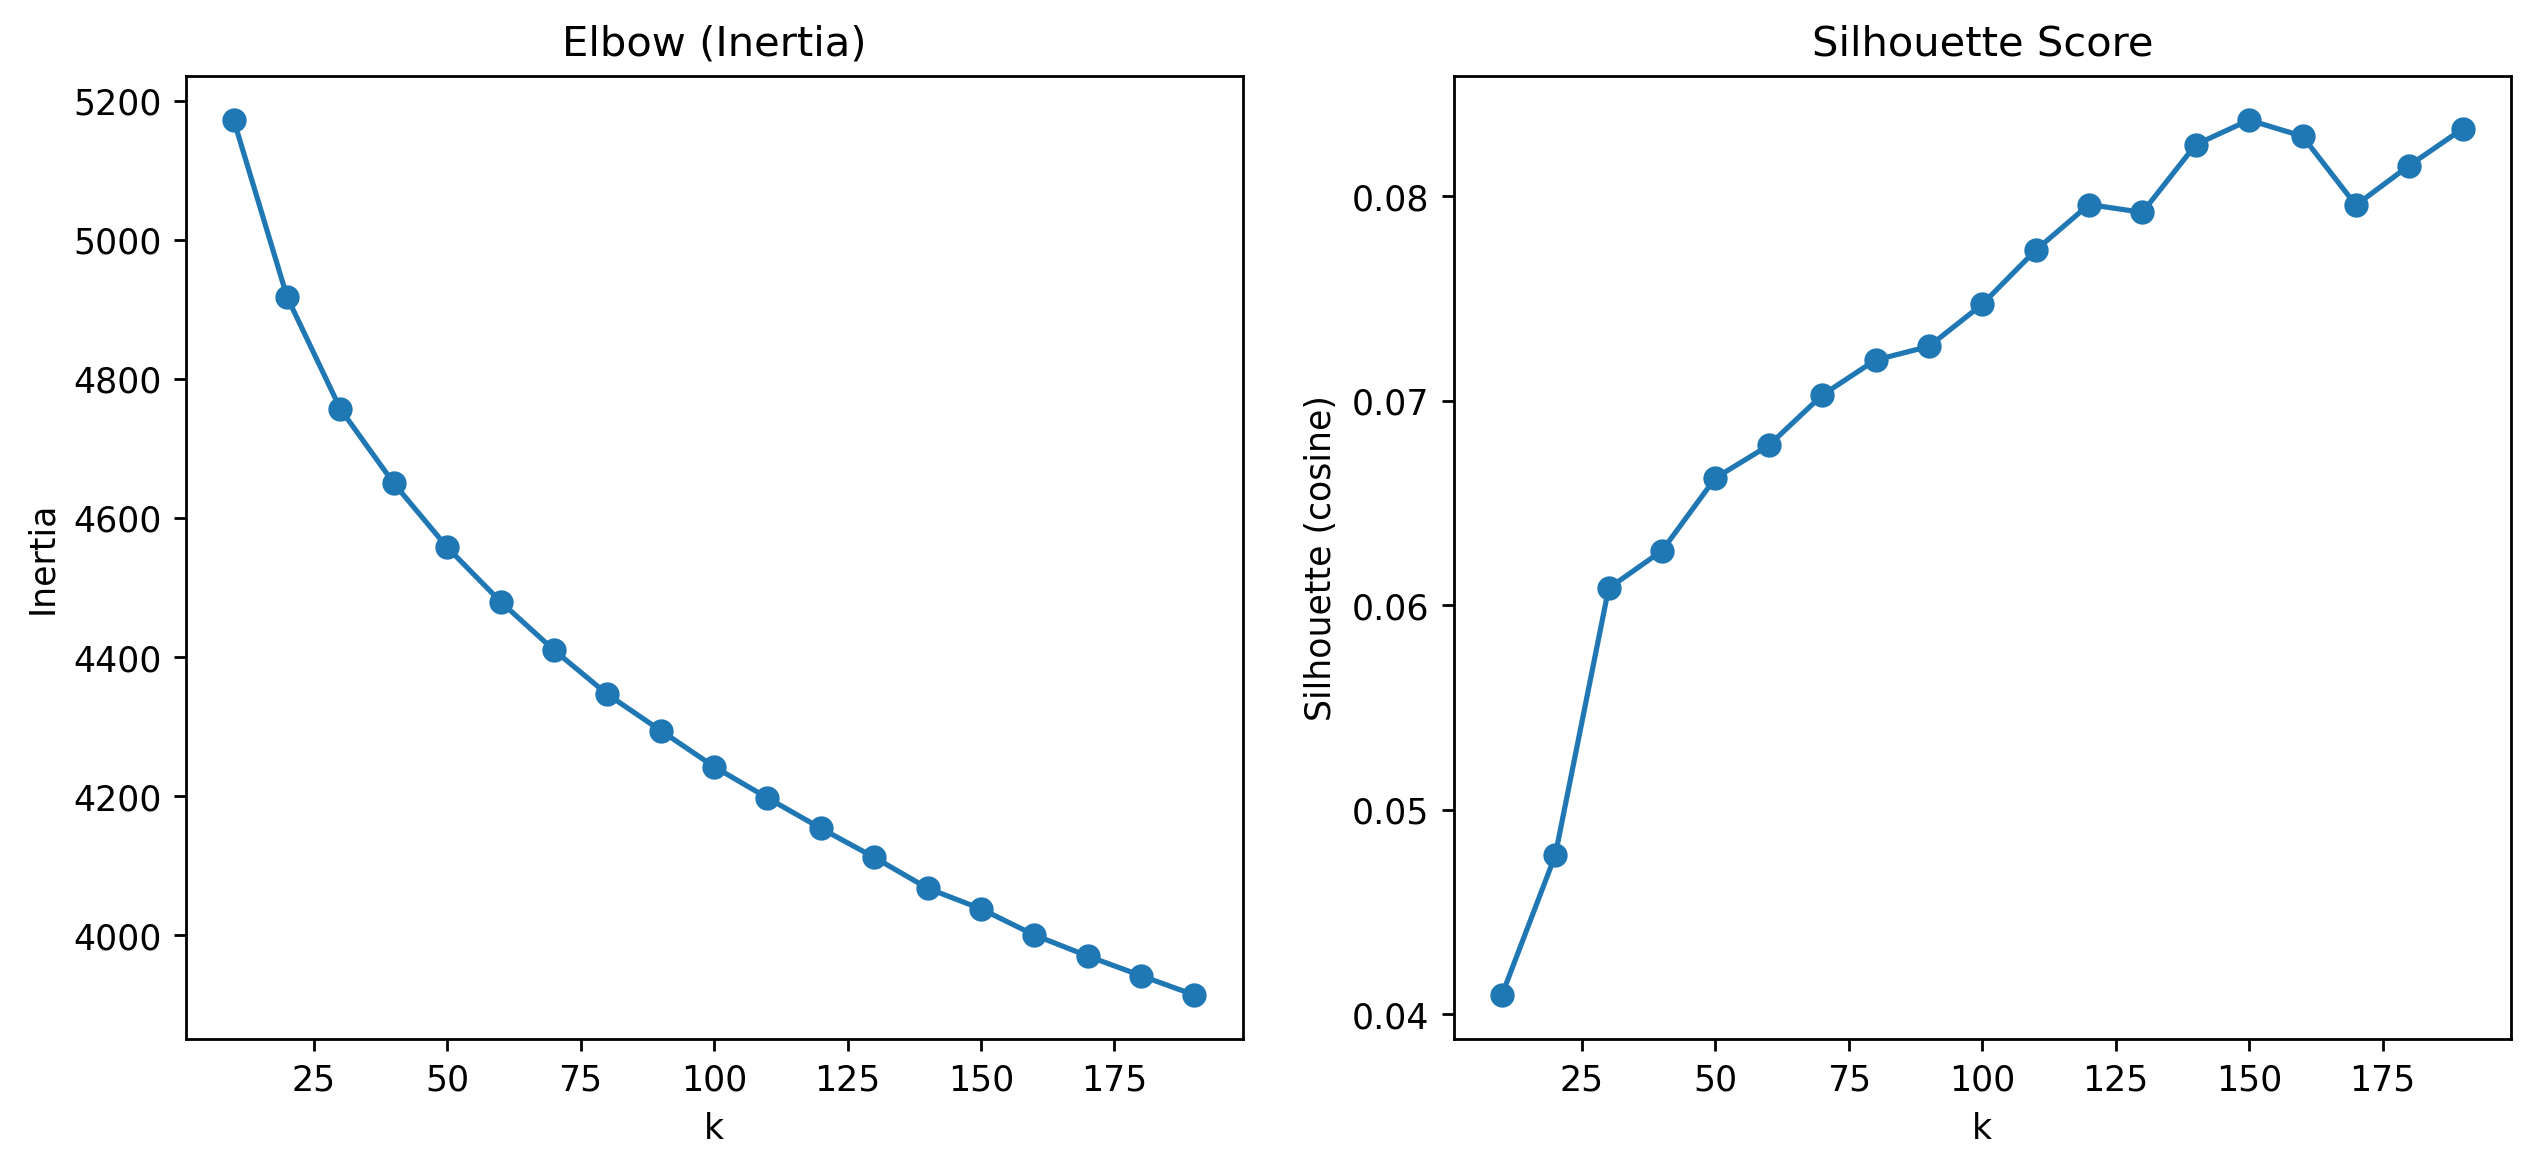

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5), dpi=250)
plt.subplot(1,2,1)
plt.plot(Ks, inertias, marker='o')
plt.title("Elbow (Inertia)")
plt.xlabel("k")
plt.ylabel("Inertia")

plt.subplot(1,2,2)
plt.plot(Ks, sil_scores, marker='o')
plt.title("Silhouette Score")
plt.xlabel("k")
plt.ylabel("Silhouette (cosine)")
plt.show()


In [5]:
N_CLUSTERS=15

In [6]:
kmeans = KMeans(n_clusters=N_CLUSTERS, init="k-means++", n_init=10, random_state=42)
labels = kmeans.fit_predict(embeddings)

/opt/miniconda3/envs/ml/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/var/folders/8r/zrjm4hxd2752djqdmtnnvk700000gn/T/ipykernel_20586/1767387524.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  palette = plt.cm.get_cmap('tab20', N_CLUSTERS)


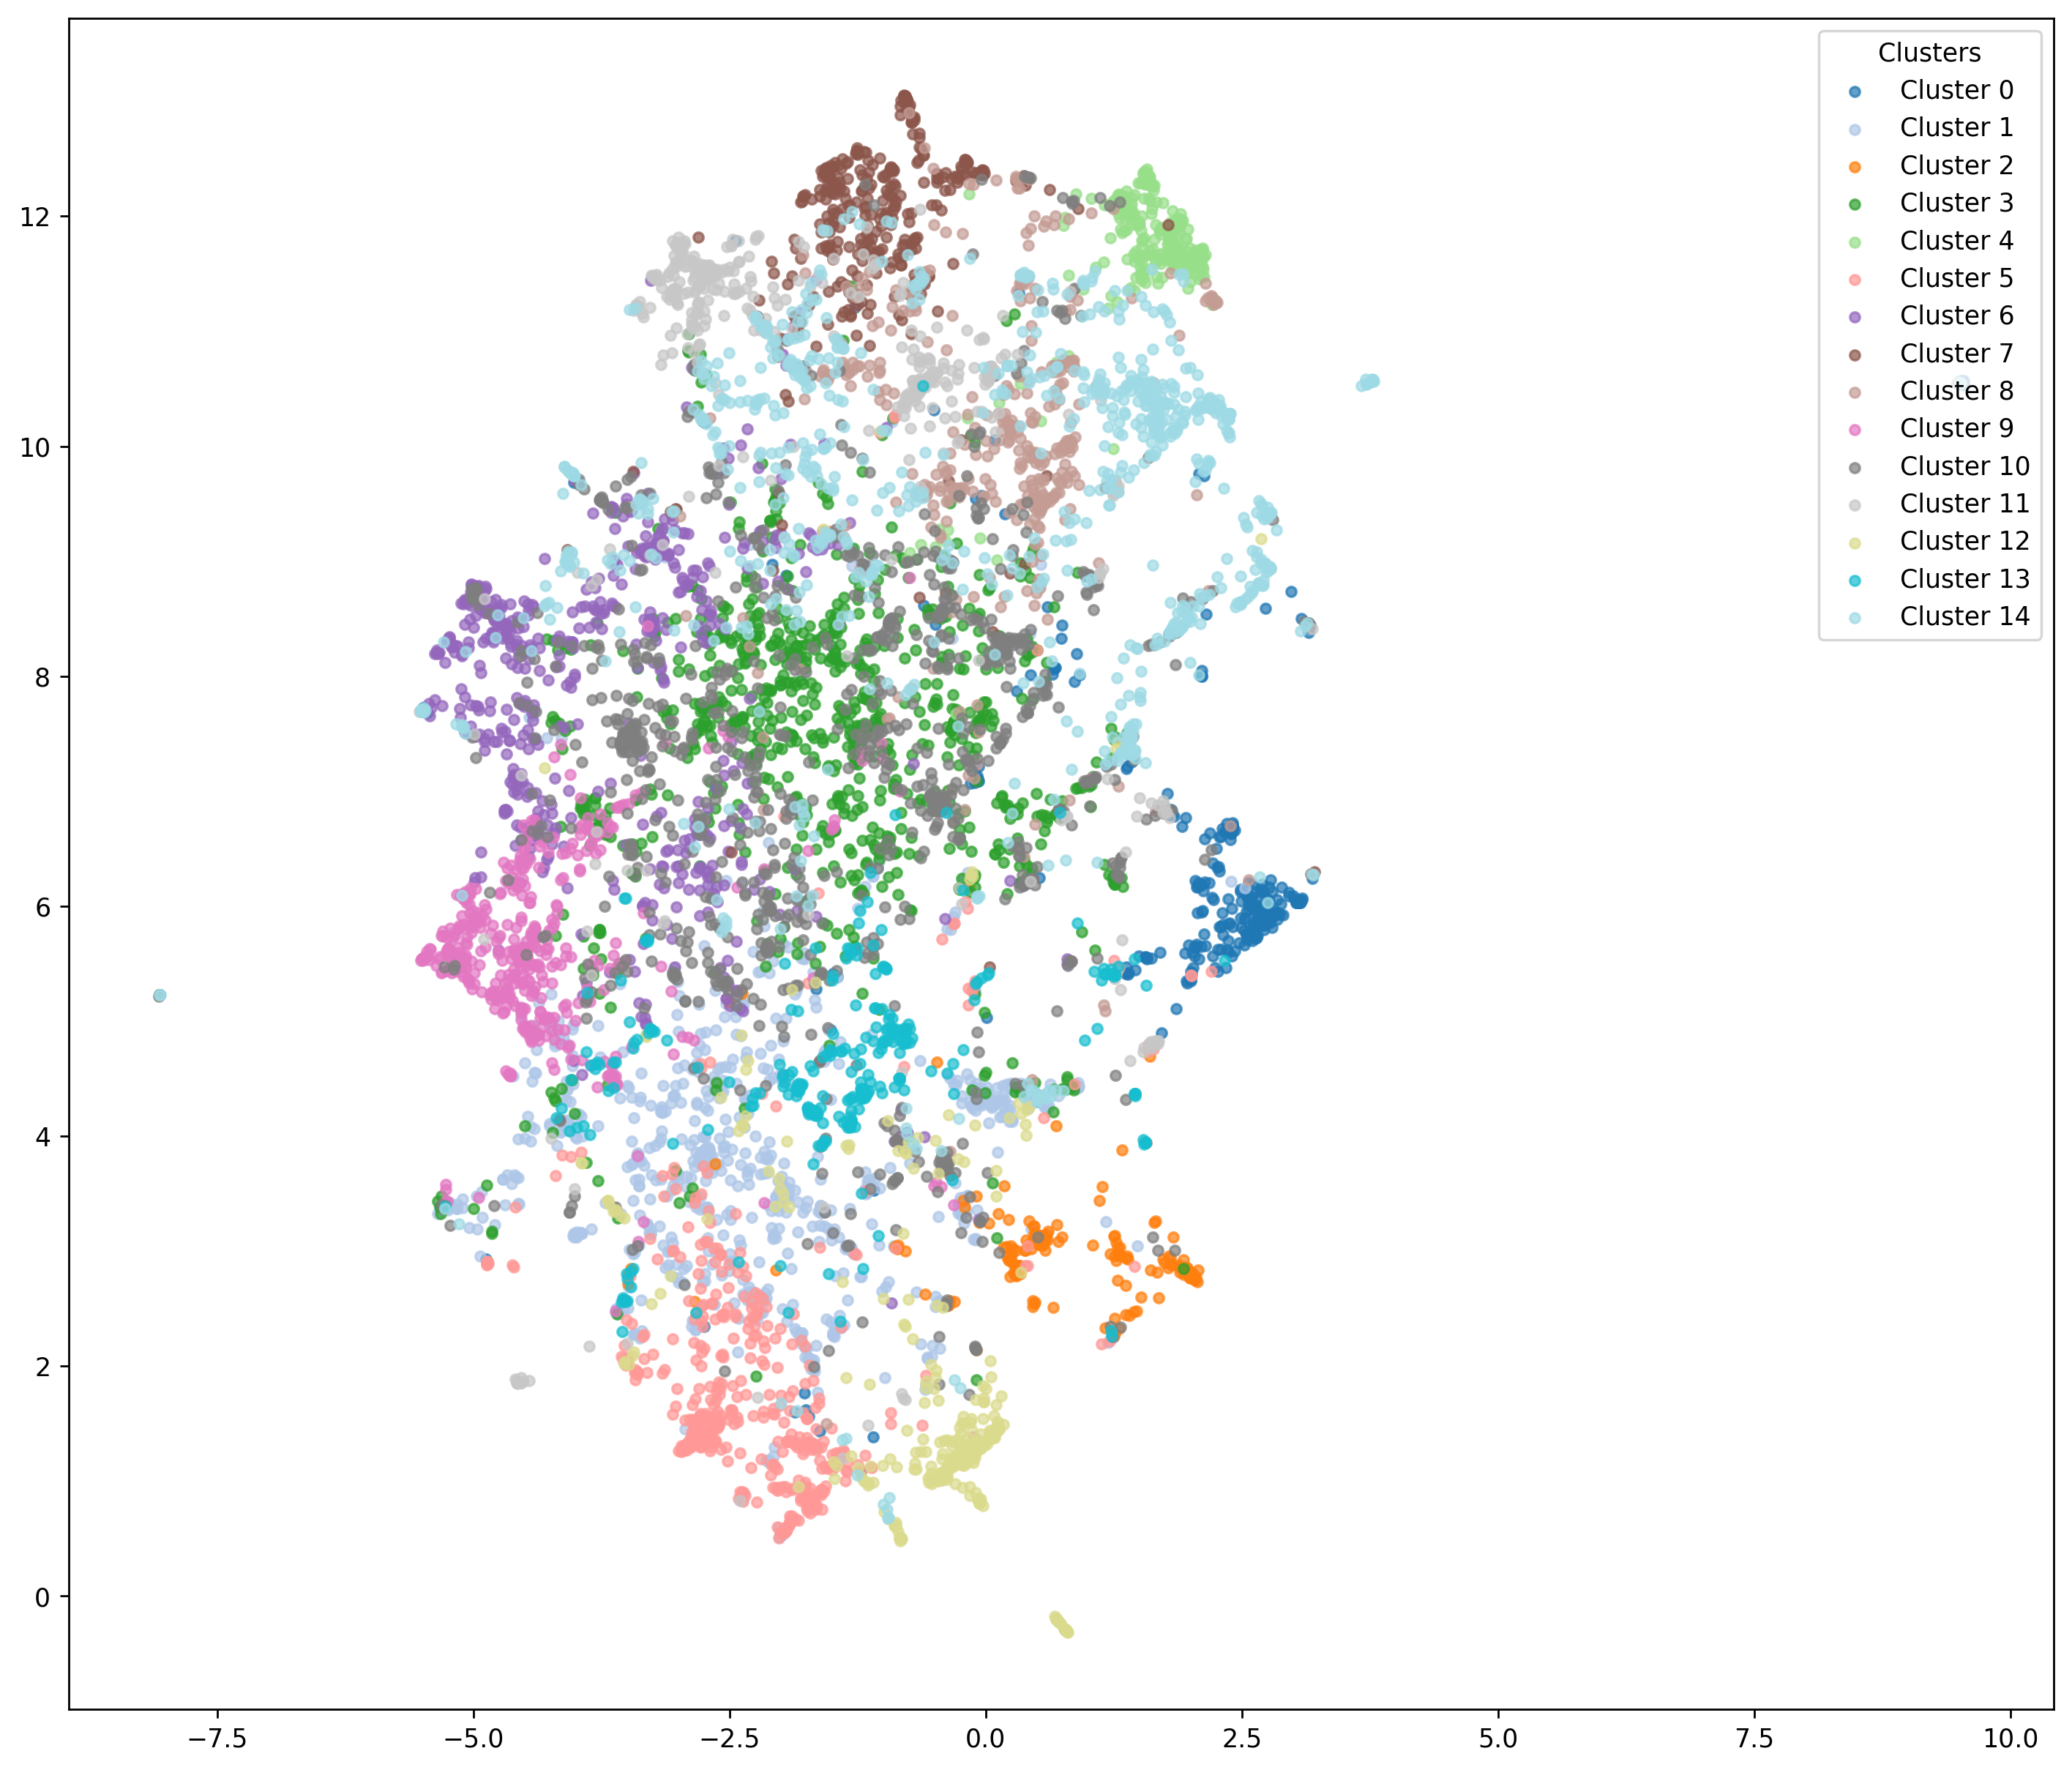

In [11]:
import json
import typing as tp
from pathlib import Path

import umap
import hdbscan
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import normalize

N_CLUSTERS = 15
reducer = umap.UMAP(n_neighbors=15, n_components=2, metric='cosine', random_state=42)
embeddings_2d = reducer.fit_transform(embeddings)

plt.figure(figsize=(14, 12), dpi=250)
palette = plt.cm.get_cmap('tab20', N_CLUSTERS)
for lbl in range(N_CLUSTERS):
    mask = labels == lbl
    plt.scatter(
        embeddings_2d[mask, 0],
        embeddings_2d[mask, 1],
        s=15,
        color=palette(lbl),
        label=f"Cluster {lbl}",
        alpha=0.7
    )

plt.legend(title="Clusters", loc="upper right")
plt.show()

In [12]:
embeddings_dict: tp.Dict[str, tp.Dict[str, tp.Any]] = {}
for i, title in enumerate(titles):
    embeddings_dict[title] = {
        "categories": emb_dict[title]['categories'],
        "cluster": int(labels[i])
    }

In [29]:
data = []
for title, info in embeddings_dict.items():
    data.append({
        "title": title,
        "categories": info["categories"],
        "cluster": info["cluster"]
    })
df = pd.DataFrame(data)

In [30]:
df[df['cluster'] == 1]

,title,categories,cluster
1,Intelligent agent,[Category:Artificial intelligence],1
2,Self-management (computer science),[Category:Artificial intelligence],1
3,Computer science,"[Category:Computer science, Category:Formal sc...",1
6,Fuzzy agent,[Category:Artificial intelligence],1
7,Bullying in information technology,"[Category:Abuse, Category:Information technolo...",1
...,...,...,...
7567,Geologic modelling,"[Category:Economic geology, Category:Geologic ...",1
7584,Lexical density,"[Category:Applied linguistics, Category:Comput...",1
7717,QZERTY,[Category:Keyboard layouts],1
7718,Thumb keyboard,[Category:Computer keyboard types],1


As one might see, the clusters aren't meaningful. Further postprocessing is required.

### Let's check what labels have we retrieved for each article

In [16]:
path = Path("../data/wiki_node_labels.json")

with open(path, "r", encoding="utf-8") as f:
    data = json.load(f)

df = pd.DataFrame.from_dict(data, orient="index")
df.reset_index(inplace=True)
df.rename(columns={"index": "title"}, inplace=True)

In [17]:
df['assigned_class'].value_counts()

assigned_class
Computer Security                             3059
Mathematics & Formal Methods                  1396
Systems & Hardware                            1083
Data Management & Databases                    849
Networking & Protocols                         650
Programming & Software                         567
Artificial Intelligence & Machine Learning     330
Name: count, dtype: int64

In [20]:
threshold = 0.8 # for uncertain cases we assign extra class 'Other'
df.loc[df['score'] < threshold, 'assigned_class'] = 'Other'

In [19]:
df['assigned_class'].value_counts()

assigned_class
Other                                         2515
Computer Security                             1760
Mathematics & Formal Methods                   925
Systems & Hardware                             920
Data Management & Databases                    581
Programming & Software                         541
Networking & Protocols                         421
Artificial Intelligence & Machine Learning     271
Name: count, dtype: int64

In [23]:
graph = json.loads(
    open(
        "../data/wiki_graph_filtered_v2.json",
        "r",
    ).read()
)

In [24]:
len(graph['edges'])

7859

In [25]:
graph['nodes']['Mean longitude']

{'title': 'Mean longitude',
 'categories': ['Category:Orbits'],
 'link': 'https://en.wikipedia.org/wiki/Mean_longitude',
 'text': 'Mean longitude is the ecliptic longitude at which an orbiting body could be found if its orbit were circular and free of perturbations. While nominally a simple longitude, in practice the mean longitude does not correspond to any one physical angle.\n\nDefinition\nDefine a reference direction, ♈︎, along the ecliptic. Typically, this is the direction of the March equinox. At this point, ecliptic longitude is 0°.\nThe body\'s orbit is generally inclined to the ecliptic, therefore define the angular distance from ♈︎ to the place where the orbit crosses the ecliptic from south to north as the longitude of the ascending node, Ω.\nDefine the angular distance along the plane of the orbit from the ascending node to the pericenter as the argument of periapsis, ω.\nDefine the mean anomaly, M, as the angular distance from the periapsis which the body would have if it 

In [26]:
texts = []
for idx, item in df.iterrows():
    text = graph['nodes'][item['title']]['text']
    texts.append(text)

In [27]:
df['text'] = texts

In [ ]:
from sentence_transformers import SentenceTransformer
from tqdm import tqdm
tqdm.pandas()
model_name = "intfloat/multilingual-e5-large-instruct"
model = SentenceTransformer(model_name, device="mps", tokenizer_kwargs={})

In [18]:
model.max_seq_length = 200

In [20]:
texts_embds = model.encode(
    df['text'],
    batch_size=8,
    show_progress_bar=True,
    convert_to_numpy=True,
    normalize_embeddings=True,
)

Batches:   0%|          | 0/992 [00:00<?, ?it/s]

In [23]:
len(df)

7934

In [27]:
df['text_embds'] = texts_embds.tolist()

In [29]:
df.to_csv("embedded_nodes.csv")

In [32]:
df.head(2)

,title,assigned_class,score,categories,text,text_embds
0,Data binding,Data Management & Databases,0.916350,[Category:Data management],"In computer programming, data-binding is a gen...","[0.031369250267744064, 0.014775759540498257, -..."
1,Intelligent agent,Artificial Intelligence & Machine Learning,0.918341,[Category:Artificial intelligence],"In artificial intelligence, an intelligent age...","[0.03515082225203514, 0.005544157698750496, -0..."


In [ ]:
import json
import pandas as pd

with open("../data/wiki_graph_filtered_v2.json") as f:
    data = json.load(f)

nodes_dict = data["nodes"]
edges_list = data["edges"]

df = df.copy()
df = df.set_index("title")
node_titles = list(nodes_dict.keys())
node_titles = [t for t in node_titles if t in df.index]

node2id = {title: i for i, title in enumerate(node_titles)}

In [ ]:
edge_index = []
for src, dst in edges_list:
    if src in node2id and dst in node2id:
        edge_index.append([node2id[src], node2id[dst]])

import torch
edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()

In [36]:
import numpy as np

x = np.stack([df.loc[title].text_embds for title in node_titles], axis=0)
x = torch.tensor(x, dtype=torch.float)

In [38]:
labels = [df.loc[t].assigned_class for t in node_titles]
classes = sorted(set(labels))
class2id = {cls: i for i, cls in enumerate(classes)}
y = torch.tensor([class2id[c] for c in labels], dtype=torch.long)

In [39]:
class2id

{'Artificial Intelligence & Machine Learning': 0,
 'Computer Security': 1,
 'Data Management & Databases': 2,
 'Mathematics & Formal Methods': 3,
 'Networking & Protocols': 4,
 'Other': 5,
 'Programming & Software': 6,
 'Systems & Hardware': 7}

In [ ]:
from torch_geometric.data import Data

graph = Data(x=x, edge_index=edge_index, y=y)

In [42]:
from torch_geometric.utils import k_hop_subgraph

def get_subgraph(node_id, k=2):
    subset, sub_edge_index, mapping, edge_mask = k_hop_subgraph(
        node_id, k, graph.edge_index, relabel_nodes=True)
    return Data(
        x=graph.x[subset],
        edge_index=sub_edge_index,
        y=graph.y[subset]
    )

In [48]:
df = df.reset_index()

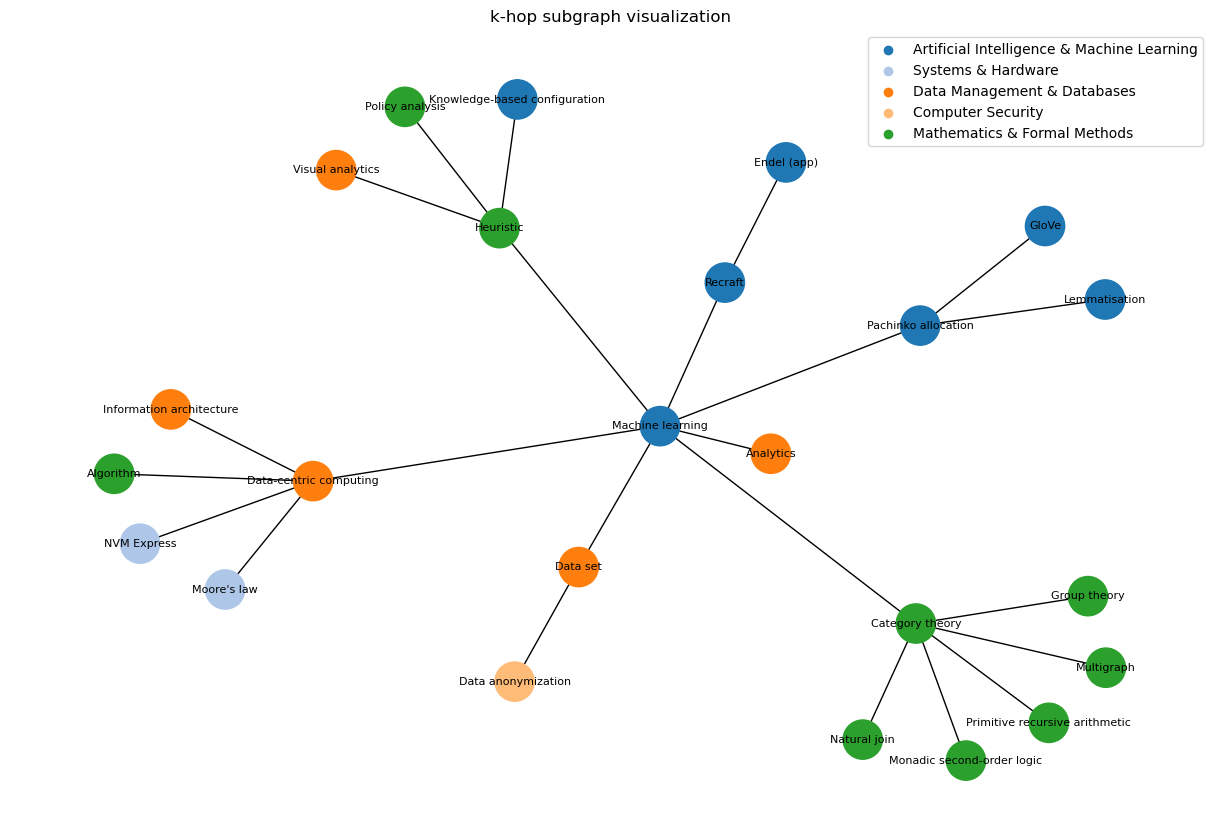

In [ ]:
import json
import networkx as nx
import matplotlib.pyplot as plt
import torch

with open(
    "/Users/chrnegor/Documents/code/gnn-wiki-project/data/wiki_graph_filtered_v2.json",
    "r",
) as f:
    data = json.load(f)

nodes = data["nodes"]
edges = data["edges"]

G = nx.Graph()
for node_title, node_data in nodes.items():
    G.add_node(node_title, **node_data)

for source, target in edges:
    G.add_edge(source, target)

classes = df["assigned_class"].unique()
class2id = {cls: i for i, cls in enumerate(classes)}

for n in G.nodes():
    match = df[df["title"] == n]
    if not match.empty:
        G.nodes[n]["class"] = match["assigned_class"].values[0]
    else:
        G.nodes[n]["class"] = None


def get_k_hop_subgraph(G, node_id, k=1):
    """
    Возвращает подграф с k-hop окрестностью вокруг node_id
    """
    if node_id not in G:
        raise ValueError(f"Node {node_id} not in graph")

    nodes_in_hop = set([node_id])
    frontier = set([node_id])
    for _ in range(k):
        next_frontier = set()
        for n in frontier:
            next_frontier.update(G.neighbors(n))
        frontier = next_frontier - nodes_in_hop
        nodes_in_hop.update(frontier)

    return G.subgraph(nodes_in_hop).copy()


def plot_graph(G, figsize=(12, 8)):
    """
    Визуализирует граф G с цветами по классам, легендой и тайтлами нод
    """
    plt.figure(figsize=figsize)

    unique_classes = list(
        {d["class"] for _, d in G.nodes(data=True) if d["class"] is not None}
    )
    class_colors = {cls: plt.cm.tab20(i) for i, cls in enumerate(unique_classes)}

    node_colors = []
    for n, d in G.nodes(data=True):
        if d["class"] is not None:
            node_colors.append(class_colors[d["class"]])
        else:
            node_colors.append("lightgrey")

    pos = nx.spring_layout(G, seed=42)
    nx.draw(
        G,
        pos,
        with_labels=True,
        labels={n: n for n in G.nodes()},
        node_color=node_colors,
        node_size=800,
        font_size=8,
    )

    for cls, color in class_colors.items():
        plt.scatter([], [], c=[color], label=cls)
    plt.legend(scatterpoints=1, fontsize=10, loc="best")

    plt.title("k-hop subgraph visualization")
    plt.show()


node_id = "Machine learning"
k = 2
subG = get_k_hop_subgraph(G, node_id, k=k)
plot_graph(subG)